In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

from sklearn.preprocessing import scale, minmax_scale
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
#plt.style.use("fivethirtyeight")

# будем отображать графики прямо в jupyter'e
%matplotlib inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [2]:
WAG = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
WAG.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Text(0, 0.5, 'зп')

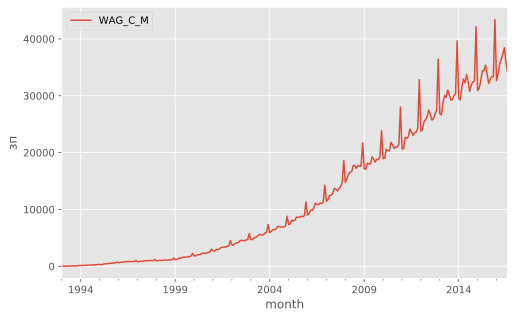

In [4]:
WAG.plot()
plt.ylabel('зп')

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


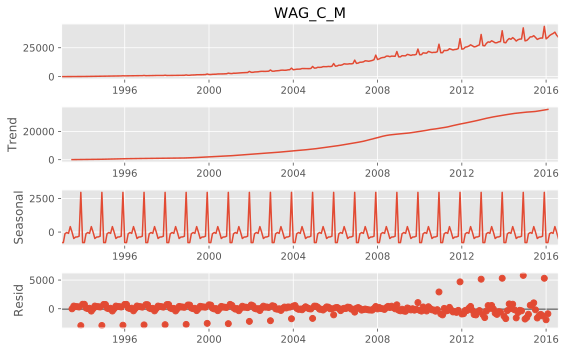

In [5]:
sm.tsa.seasonal_decompose(WAG.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M)[1])

# Стабилизация дисперсии
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


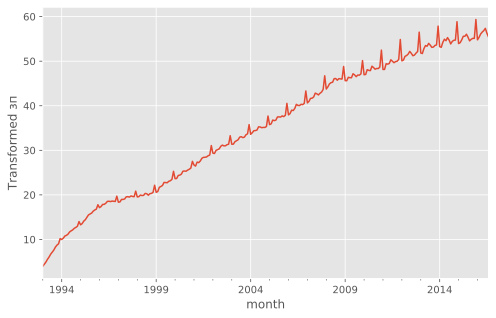

In [6]:
WAG['WAG_box'], lmbda = sp.stats.boxcox(WAG.WAG_C_M)
WAG.WAG_box.plot()
plt.ylabel(u'Transformed зп')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_box)[1])

# Стационарность
Критерий Дики-Фуллера не отвергает гипотезу нестационарности и визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WAG_C_M    284 non-null    float64
 1   WAG_box    284 non-null    float64
 2   WAG_diff1  272 non-null    float64
dtypes: float64(3)
memory usage: 8.9 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 272 entries, 1994-01-01 to 2016-08-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WAG_C_M    272 non-null    float64
 1   WAG_box    272 non-null    float64
 2   WAG_diff1  272 non-null    float64
dtypes: float64(3)
memory usage: 8.5 KB
None
Критерий Дики-Фуллера: p=0.014697


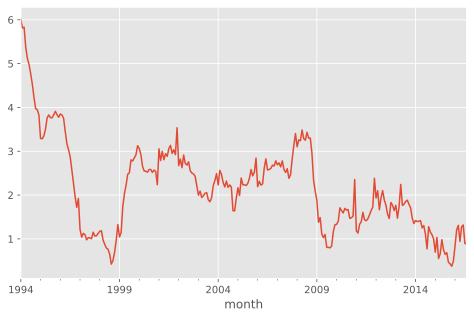

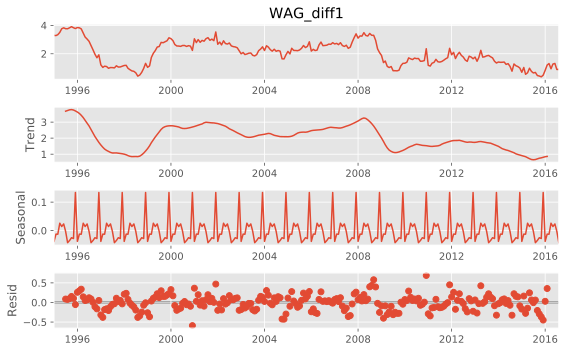

In [7]:
WAG['WAG_diff1'] = WAG.WAG_box - WAG.WAG_box.shift(12)
print(WAG.info())
WAG.dropna(inplace=True)
print(WAG.info())
WAG.WAG_diff1.plot()

sm.tsa.seasonal_decompose(WAG.WAG_diff1[12:]).plot()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_diff1)[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 272 entries, 1994-01-01 to 2016-08-01
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WAG_C_M    272 non-null    float64
 1   WAG_box    272 non-null    float64
 2   WAG_diff1  272 non-null    float64
 3   WAG_diff2  271 non-null    float64
dtypes: float64(4)
memory usage: 10.6 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 271 entries, 1994-02-01 to 2016-08-01
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WAG_C_M    271 non-null    float64
 1   WAG_box    271 non-null    float64
 2   WAG_diff1  271 non-null    float64
 3   WAG_diff2  271 non-null    float64
dtypes: float64(4)
memory usage: 10.6 KB
None
Критерий Дики-Фуллера: p=0.000000


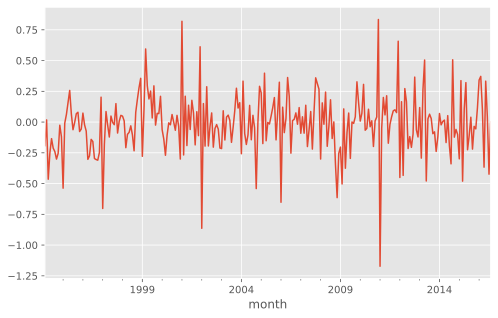

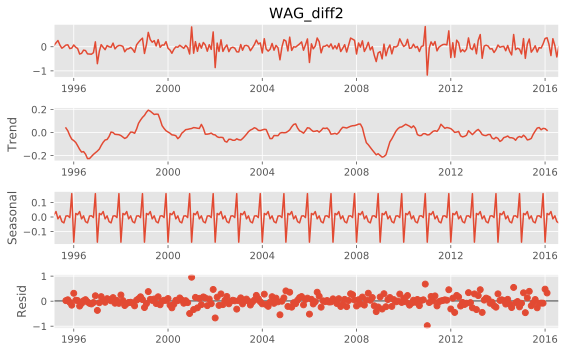

In [8]:
WAG['WAG_diff2'] = WAG.WAG_diff1 - WAG.WAG_diff1.shift(1)
print(WAG.info())
WAG.dropna(inplace=True)
print(WAG.info())
WAG.WAG_diff2.plot()

sm.tsa.seasonal_decompose(WAG.WAG_diff2[13:]).plot()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_diff2)[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

# Подбор модели
Посмотрим на ACF и PACF полученного ряда:

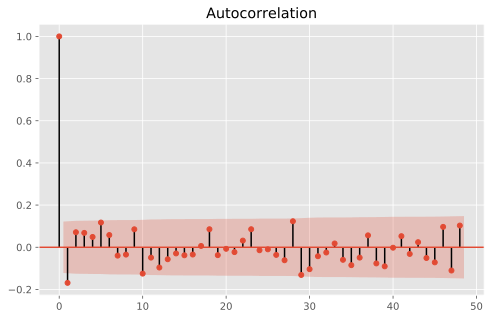

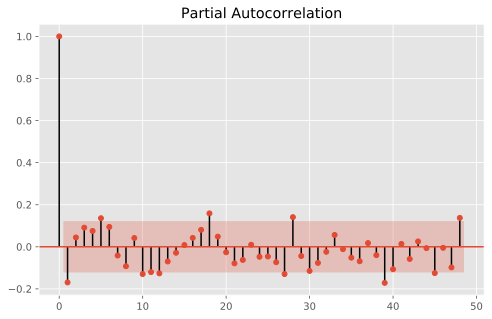

In [9]:
sm.graphics.tsa.plot_acf(WAG.WAG_diff2[13:].values.squeeze(), lags=48)
sm.graphics.tsa.plot_pacf(WAG.WAG_diff2[13:].values.squeeze(), lags=48)
plt.show()

Начальные приближения возьмем: 
Q=0, так как нет значимых сезонных лагов.
q=1, как вообще единственный лаг
P=4, сезоных лагов несколько - 12 и 48. Последний - 48, значит мы можем взять Р=48/12=4
p=5, не сезонных лагов много. Рассмотрим только те, что меньше значения сезоннсти 12 - последний лаг меньше 12 равен 5.

In [10]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.WAG_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 6min 8s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
56  (5, 1, 1, 0) -5.291280
36  (3, 1, 1, 0) -5.285763
51  (5, 0, 1, 0) -5.002078
26  (2, 1, 1, 0) -4.418949
46  (4, 1, 1, 0) -4.268792


Лучшая модель:

In [13]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             WAG_box   No. Observations:                  271
Model:             SARIMAX(5, 1, 1)x(1, 1, [], 12)   Log Likelihood                  10.646
Date:                             Sun, 10 Jan 2021   AIC                             -5.291
Time:                                     11:37:07   BIC                             23.132
Sample:                                 02-01-1994   HQIC                             6.138
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1689      0.486      0.347      0.728      -0.784       1.122
ar.L2          0.0866      

Её остатки:

Критерий Стьюдента: p=0.557556
Критерий Дики-Фуллера: p=0.000000


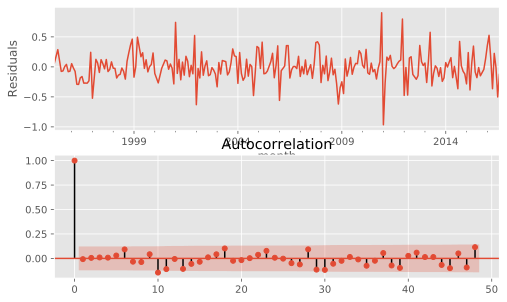

In [14]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % sp.stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:


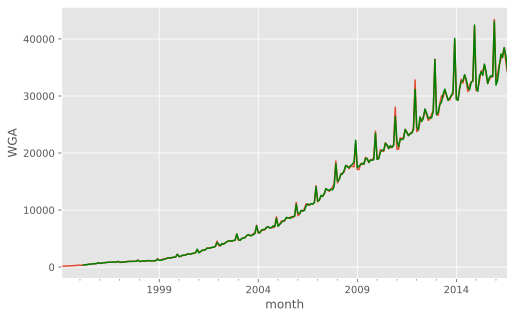

In [15]:
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)
WAG.WAG_C_M.plot()
WAG.model[13:].plot(color='g')
plt.ylabel('WGA')
plt.show()

In [16]:
print(WAG)

            WAG_C_M    WAG_box  WAG_diff1  WAG_diff2         model
month                                                             
1994-02-01    144.7  10.272455   5.813697  -0.192106      1.000000
1994-03-01    164.8  10.762540   5.830905   0.017208    144.699998
1994-04-01    171.5  10.916080   5.366650  -0.464255    164.800000
1994-05-01    183.5  11.180371   5.116965  -0.249685    171.500001
1994-06-01    207.5  11.672918   4.982199  -0.134766    183.500001
...             ...        ...        ...        ...           ...
2016-04-01  36497.0  56.526742   0.942729  -0.366210  37341.363639
2016-05-01  37270.0  56.860441   1.275065   0.332336  36749.081829
2016-06-01  38447.0  57.358885   1.316994   0.041929  38467.658823
2016-07-01  35888.0  56.260153   0.893671  -0.423323  37039.811695
2016-08-01  34095.0  55.455409   0.896620   0.002949  34371.561115

[271 rows x 5 columns]


# Прогноз:

In [17]:
import calendar
from dateutil.relativedelta import *


WAG2 = WAG[['WAG_C_M']]
date_list = [datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,40)]
future = pd.DataFrame(index=date_list, columns= WAG2.columns)
WAG2 = pd.concat([WAG2, future])


print(WAG2)

NameError: name 'datetime' is not defined

In [ ]:
WAG2['forecast'] = invboxcox(best_model.predict(start=272, end=311), lmbda)
print(WAG2)

WAG2.WAG_C_M.plot()
WAG2.forecast.plot(color='b')
plt.ylabel('WAG')
plt.show()

Отличный прогноз визуально хорошо описывающий повышающийся тренд и немного растущую дисперсию сезонности.
Сравним полученный прогноз с реальными данными по среднемесячной заработной плате в России (https://drive.google.com/file/d/1MCPInyoD776TPFX7mU67lQ-x6qiPp8IE/view?usp=sharing)

In [ ]:
WAG_R = pd.read_csv('salary_sept_2020.csv', index_col=['month'], parse_dates=['month'], dayfirst=True, decimal=',')

In [ ]:
WAG_R.head()

In [ ]:

WAG2.forecast.plot(color='g')
WAG_R.salary.plot(color='r')
plt.ylabel('WAG')
plt.show()

Отличный прогноз. Хотя не так близко предсказывает повышающийся тренд, но и рост начался резко с этого периода. Также в реальности более широкая дисперсия у сезонных колебаний, но и выросла она резко. Прогноз опирался на предыдущие данные, где рост был более плавным. Поэтому прогноз получился адекватен.